In [82]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import scipy.stats as stats
import statistics
import os
import math 
from utils import *
plt.rcParams['text.usetex'] = True

%config InlineBackend.figure_formats = ['svg']
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Playground Notebook for the article :

## *\"Pick The Largest Margin for Robust Detection of Splicing"*
 
Through this notebook you will be able to retrieve some results we showed in the article.
    
Please note that some functions of the notebooks are written in ```utils.py```.

## I - Link between latent margins and generalization gaps

We precomputed the latent margins of each model using the code ```margins.py``` and gathered them in the folder ```margins_data```. 

With these data, it is then possible to reproduce our figures following the code below.

In [186]:
'''
Load the dataframe containing the accuracies on source test set 
as well as the generalization gaps observed for each target.
'''

df=pd.read_csv('accuracy_on_source_and_gen_gap.csv')
df.head(10)

,model_name,Accuracy_test_source,Gen_Gap_pipeline_1,Gen_Gap_pipeline_2,Gen_Gap_pipeline_3,Gen_Gap_pipeline_4,Gen_Gap_pipeline_5,Gen_Gap_pipeline_6,Gen_Gap_pipeline_7,Gen_Gap_pipeline_8,...,Gen_Gap_pipeline_11,Gen_Gap_pipeline_12,Gen_Gap_pipeline_13,Gen_Gap_pipeline_14,Gen_Gap_pipeline_15,Gen_Gap_pipeline_16,Gen_Gap_pipeline_17,Gen_Gap_pipeline_18,Gen_Gap_pipeline_19,Gen_Gap_pipeline_20
0,model_1,85.488427,6.126487,10.756636,8.046305,8.413327,4.827785,10.050821,8.385098,8.808583,...,8.469790,9.542632,4.291362,9.373236,8.469790,9.853190,6.917000,9.006214,8.695656,10.502541
1,model_2,77.413893,3.303218,7.453418,7.227558,6.888765,1.693958,6.013554,6.324112,6.013554,...,7.171094,6.041789,2.569175,5.985320,5.731225,4.404294,1.693958,5.223042,5.025411,4.206663
2,model_3,87.351781,8.893281,10.417843,10.784870,10.304916,6.945229,10.474312,10.502541,9.514403,...,11.434221,10.191983,7.509881,9.937888,11.349523,10.671937,8.385098,10.220218,9.937888,11.236590
3,model_4,80.208921,1.919818,4.856014,2.851498,3.783172,1.383400,3.274983,3.754944,4.376060,...,3.190285,4.009032,1.552796,2.766800,3.613776,5.081874,2.936196,2.315074,4.460758,4.545456
4,model_5,87.210613,15.330321,21.061546,21.118009,20.440429,14.906830,20.892149,19.339353,18.944097,...,19.649911,17.814791,15.556180,19.198191,18.802935,17.193675,16.205531,19.226426,17.080742,16.798419
5,model_6,80.350083,2.117449,4.799545,4.291362,3.698474,1.468098,3.049123,2.823263,3.698474,...,3.754938,2.597404,2.682102,2.484471,2.992660,2.710330,3.077358,2.145678,3.049123,4.545450
6,model_7,85.544890,12.874085,18.125355,16.403162,16.374928,12.365896,17.843026,16.516095,15.302092,...,16.262001,14.991528,14.596272,17.363071,16.318464,14.229250,13.692832,16.629022,15.132695,15.245622
7,model_8,74.280065,1.693958,2.823263,1.750422,2.315074,0.451720,1.609260,1.298702,2.399772,...,2.117443,0.762278,2.343309,1.637489,2.540934,1.665723,2.738565,1.665723,1.439863,2.004516
8,model_9,77.300960,3.529078,6.437039,5.900621,5.702990,2.428007,5.844158,5.053639,5.307734,...,5.646527,4.009032,0.818747,4.658383,4.940712,4.488987,1.637495,4.601920,3.303218,4.404289
9,model_10,80.830038,9.740257,15.330321,14.906830,13.043475,8.441556,13.043475,12.789381,12.394124,...,13.043475,11.236590,9.514397,12.478822,12.281197,10.643703,8.554488,11.885941,10.135514,10.700166


In [96]:
#Set of models presenting a test accuracy on the source upper than 75%.
relevant_models=df.iloc[0:][df["Accuracy_test_source"]>=75].model_name
#Discard the less efficient models enables to avoid low generalisation gaps caused by underfitting.

In [103]:
# Dictionary to store positive margins per model
mu_margins_per_model = {}

for i in range(len(model_files_list)):
    model = pd.read_csv(model_files_list[i])
    
    #discard negative margins as the authors of [19]
    model[model < 0] = np.nan
    model = model.dropna()
    
    #compute descriptive statistics of margin distributions (mu vector in the paper)
    #the function called here is in utils.py
    margin_stats = {col: calculate_statistics(model[col]) for col in model.columns}
    mu_margins_per_model[f'model_{i+1}'] = margin_stats

The function ```plot_gen_gap_wrt_margin``` takes as input a floating power alpha, plots a quantile plot exhibiting the correlation between our margin metric $\mathcal M_{\alpha}$ and our generalisation gap $\mathcal G$ and returns a dictionary mapping each model to its margin metrics estimated by layer $\mathcal M_{\alpha}(\mathtt{layer})$.


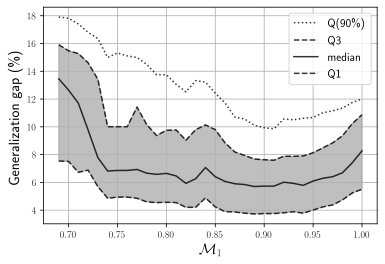

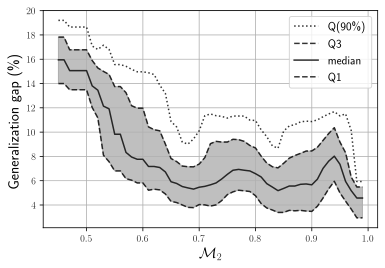

In [192]:
def plot_gen_gap_wrt_margin(alpha,plot=True):
    plt.figure()
    #list to store global margin metrics m per model
    margin_metric=[]
    #dictionary to store margin metrics m per layer of each model
    margin_metric_per_layer=copy.deepcopy(mu_margins_per_model)
    
    for model in mu_margins_per_model.keys():
        total_metric=0
        for layer in mu_margins_per_model[model]:
            margin_metric_per_layer[model][layer]=np.sum(np.power(mu_margins_per_model[model][layer],alpha))
            total_metric+=margin_metric_per_layer[model][layer]
            
        margin_metric.append(total_metric)
    margin_metric=np.array(margin_metric)
    
    model_margins=margin_metric[relevant_models.index]
    #max normalization
    model_margins=(np.array(model_margins)/(np.max(model_margins))).tolist()
        
    all_margins=copy.deepcopy(model_margins)
    all_gen_gaps=df.iloc[relevant_models.index]['Gen_Gap_pipeline_1'].values.tolist()
    for i in range(2,21):
        all_margins+=model_margins
        all_gen_gaps=all_gen_gaps+df.iloc[relevant_models.index][f'Gen_Gap_pipeline_{i}'].values.tolist()
    if plot:
        #plot quantile plot with steps of size 0.01 and a window of size 0.1
        _,_=median_plot(np.array(all_margins),np.array(all_gen_gaps),f"$\mathcal M_{alpha}$",slide=0.05,gap=0.01,alpha=0.8,fontsize=15);
    return margin_metric_per_layer

margin_metric_per_layer_1=plot_gen_gap_wrt_margin(1)
margin_metric_per_layer_2=plot_gen_gap_wrt_margin(2)

## II - Link between latent margins per layer and generalization gaps

The function ```plot_gen_gap_wrt_margin_per_layer``` takes as input a floating power alpha and plots a quantile plot exhibiting the correlation between our margin metric for each layer $\mathcal M_{\alpha}(\mathtt{layer})$ and our generalisation gap $\mathcal G$.


In [201]:
def plot_gen_gap_wrt_margin_per_layer(alpha):
    margin_metric_per_layer=plot_gen_gap_wrt_margin(alpha,plot=False)
    plt.figure(figsize=(12,10))

    #a dictionary to store normalized margin metrics by layer for each model
    margin_layers_wrt_each_model={}

    for layer in margin_metric_per_layer['model_1'].keys():
        margins_per_model=[]
        for index in relevant_models.index:
            margins_per_model.append(margin_metric_per_layer[f'model_{index+1}'][layer])
        margin_layers_wrt_each_model[layer]=np.array(margins_per_model)
        margin_layers_wrt_each_model[layer]=(margin_layers_wrt_each_model[layer]/margin_layers_wrt_each_model[layer].max()).tolist()

    for i,layer in enumerate(margin_layers_wrt_each_model.keys()):
            all_margins=copy.deepcopy(margin_layers_wrt_each_model[layer])
            all_gen_gaps=df.iloc[relevant_models.index]['Gen_Gap_pipeline_1'].values.tolist()
            for j in range(2,21):
                all_margins+=margin_layers_wrt_each_model[layer]
                all_gen_gaps=all_gen_gaps+df.iloc[relevant_models.index][f'Gen_Gap_pipeline_{j}'].values.tolist()

            plt.subplot(3,3,i+1)
            _,_=median_plot(np.array(all_margins),np.array(all_gen_gaps),f"$\mathcal M_{alpha}(\mathtt{{{layer}}})$",slide=0.1*(alpha),gap=0.01,alpha=0.8,fontsize=15);
    plt.tight_layout()

<Figure size 432x288 with 0 Axes>

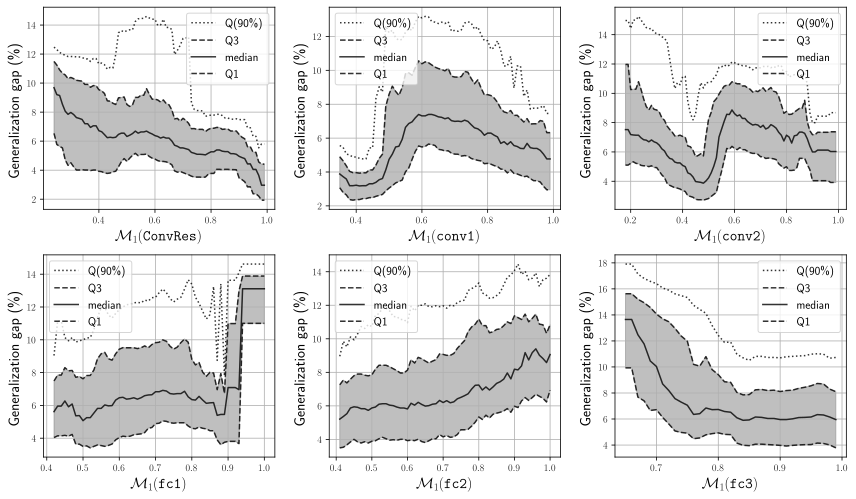

In [203]:
plot_gen_gap_wrt_margin_per_layer(1)

<Figure size 432x288 with 0 Axes>

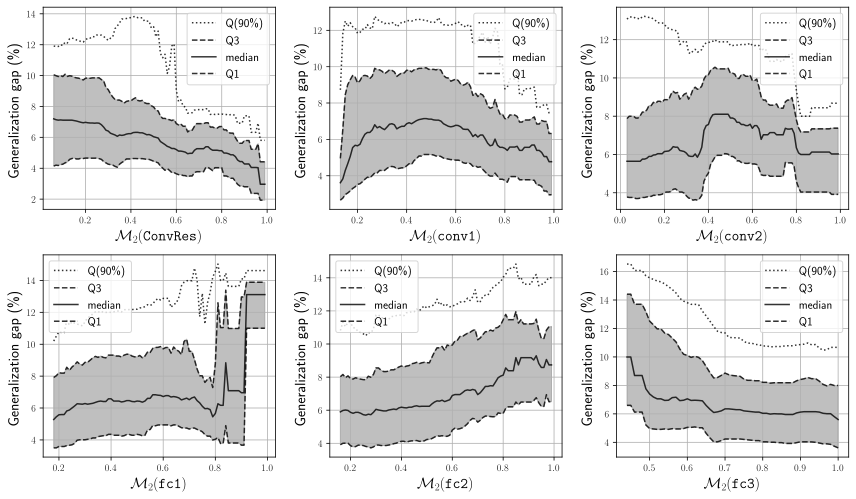

In [204]:
plot_gen_gap_wrt_margin_per_layer(2)

#### As we presented in the paper, there is clear correlation between margin metrics of first and last layer of the Bayar detector and its ability to be robust against post-processing attacks.

## III - Impact of parameters and operators on robust detection

In this part, we provide the code enabling to retrieve the results displayed in Table II of the paper.

In [206]:
#load the csv file containing information about each architecture (normalization, dropout, etc.)
df_archi=pd.read_csv('training_results.csv')
#we add to that file the list of accuracies on the source test set per model.
df_archi['Accuracy_test_source']=df["Accuracy_test_source"]
df_archi.columns=['model_name']+df_archi.columns[1:].tolist()
#as explained in the paper, we propose here to compute the margin metric with alpha=2 and only using 
#margin metrics from first and last layers.
first_and_last_margin_metric=[margin_metric_per_layer_2[f'model_{i}']['ConvRes']+margin_metric_per_layer_2[f'model_{i}']['fc3'] for i in range(1,201)]
#max normalization
first_and_last_margin_metric=(np.array(first_and_last_margin_metric)/(np.max(first_and_last_margin_metric))).tolist()
df_archi['margin']=first_and_last_margin_metric

The code below enables to retrieve each line of the Table II of our paper. You just have to indicates in the first line what operation you want to analyze among "Pooling"," Batch Size", "Normalization" and "Dropout Rate".

In [209]:
for i in np.unique(df_archi['Pooling']):
    print('\n')
    print(f'Pooling: {i}')
    print('Source Accuracy')
    print(np.median(df_archi.iloc[relevant_models.index][df_archi['Pooling']==i]['Accuracy_test_source']),'%')
    print('Margin')
    print(np.median(df_archi.iloc[relevant_models.index][df_archi['Pooling']==i]['margin']))
    print('Quantiles')
    for k in [0,0.25,0.5,0.75,1]:
        print(np.quantile(df.iloc[df_archi.iloc[relevant_models.index][df_archi['Pooling']==i].index].values[:,2:].reshape(-1),k),
            '%')



Pooling: average_pooling
Source Accuracy
81.56408667564392 %
Margin
0.8328747592025425
Quantiles
-0.1411616802215576 %
3.8890480995178227 %
6.691133975982666 %
9.542632102966309 %
15.330320596694946 %


Pooling: max_pooling
Source Accuracy
82.55223035812378 %
Margin
0.6976856632695585
Quantiles
-0.08469820022583 %
4.630152881145477 %
6.211179494857788 %
8.335687220096588 %
21.118009090423584 %


If you want to move further in this direction, we invite you to play with the latent margins we computed to derive your own margin metric $\mathcal M$ and test if it is more or less correlated that the one we crafted.